# Setup

In [ ]:
# ResNet reference: https://www.kaggle.com/aadhavvignesh/pytorch-garbage-classification-95-accuracy
# PyTorch data preprocessing reference: https://www.kaggle.com/altanai/garbage-segrigation-on-pytorch-95-accuracy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()  

#Set the run time to be GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [ ]:
# from google.colab import drive
# drive.mount("/content/drive")
# data_dir = "/content/drive/My Drive/cis519/project/Garbage classification"
# data_dir = "/content/drive/My Drive/garbage_data/Garbage_classification/Garbage_classification"

data_dir = "../Garbage_classification/Garbage_classification"
classes = os.listdir(data_dir)
print(classes)

Mounted at /content/drive
['metal', 'cardboard', 'plastic', 'glass', 'paper', 'trash']


In [ ]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

# Transform the image to be size 28 * 28
transformations = transforms.Compose([ transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = ImageFolder(data_dir, transform = transformations)

dataset

Dataset ImageFolder
    Number of datapoints: 2527
    Root location: /content/drive/My Drive/cis519/project/Garbage classification
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:
#A helper function to see image and its corresponding label
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: cardboard (Class No: 0)


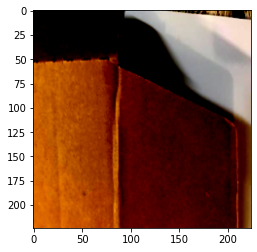

In [ ]:
img, label = dataset[366]
show_sample(img, label)

In [ ]:
print(dataset.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


# Loading Data

In [ ]:
# Set Random Seed
random_seed = 42
torch.manual_seed(random_seed)

In [ ]:
from torch.utils import data
train_ds, val_ds, test_ds = data.random_split(dataset, [1593, 176, 758])
len(train_ds), len(val_ds), len(test_ds)

(1593, 176, 758)

In [ ]:
train_ds

In [ ]:
val_ds

In [ ]:
test_ds

Data Augmentation

In [ ]:
from torch.utils.data import ConcatDataset

aug_flag = 0 # 0: no augmentation; 1: augmentation

class dataAug():
  def __init__(self,data,transforms = None):
    self.data = data
    self.transforms = transforms
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    x, y = self.data[index]
        
    if self.transforms:
      x = self.transforms(x)
        
    return x, y

augTrans = transforms.Compose([transforms.RandomVerticalFlip(p=0.5),
     transforms.RandomRotation(15),
     transforms.RandomHorizontalFlip(p=0.5)])
if aug_flag==1:
  train_aug = dataAug(train_ds,augTrans)
  train_ds = ConcatDataset([train_ds,train_aug])
  print(len(train_ds))

In [ ]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 2, pin_memory = True)
test_dl = DataLoader(test_ds,batch_size*2,num_workers=2,pin_memory=True)

In [ ]:
#Helper function to visualize batches
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

In [ ]:
# show_batch(train_dl)

In [ ]:
# show_batch(val_dl)

# ResNet-50


Reference1: https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce

Reference2: https://debuggercafe.com/transfer-learning-with-pytorch/

## Loading Model

In [ ]:
from torchvision import models
model = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
print(model)

## Freeze weights & Update classifier

In [ ]:
# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# import torch.nn as nn
# Add on classifier
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
                      nn.Linear(num_ftrs, 1024), 
                      nn.ReLU(), 
                      nn.Linear(1024, 256),
                      nn.ReLU(),
                      nn.Dropout(0.2), 
                      nn.Linear(256, len(classes)),
                      # nn.Linear(num_ftrs, len(classes)),
                      nn.LogSoftmax(dim=1))
# model.fc = nn.Linear(num_ftrs,len(classes))
# model.fc = nn.Flatten()

In [ ]:
model.fc

In [ ]:
model

## Training

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
model = model.cuda()

In [ ]:
from torchsummary import summary
summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,



*   Feature Extraction



In [ ]:
from torch import optim
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def get_validaion_loss(model):
  loss = 0
  total = 0 
  with torch.no_grad():
    for data in val_dl:
        images, labels = data
        total += labels.size(0)
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        loss += criterion(outputs, labels).item()
  return loss / total

In [ ]:
training_loss = []
validaion_loss = []
model_val_best = model
val_best = 1000
for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dl, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # print(loss.item())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 0:    # print every epoch
          print('Epoch: %d loss: %.3f' % (epoch + 1, running_loss/50))
          # print("val:", validaion_loss)
          training_loss.append(running_loss/50)
          val_acc = get_validaion_loss(model)
          validaion_loss.append(val_acc)
          print("val:", val_acc)
          running_loss = 0.0
          if val_best > val_acc:
            model_val_best = model
            val_best = val_acc

print('Finished Training')
# torch.save(model_val_best, 'baseline_model.pth')

In [ ]:
# print(training_loss, validaion_loss)

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(training_loss)
plt.plot(validaion_loss)
plt.legend(['Train', 'Validation'])
plt.title('ResNet50+SVM')

## Test

In [ ]:
model = model_val_best

In [ ]:
with torch.no_grad():
    i = 0
    for data in train_dl:
        images, labels = data
        outputs = model(images.cuda()).cpu().numpy()
        if i == 0:
          train_feat = outputs
          train_label = labels.numpy()
          i = i+1
        else:
          train_feat = np.concatenate((train_feat,outputs),axis=0)
          train_label = np.concatenate((train_label,labels.numpy()),axis=0)
    print(train_feat.shape)
    print(train_label.shape)

In [ ]:
with torch.no_grad():
    i = 0
    for data in val_dl:
        images, labels = data
        outputs = model(images.cuda()).cpu().numpy()
        if i == 0:
          val_feat = outputs
          val_label = labels.numpy()
          i = i+1
        else:
          val_feat = np.concatenate((val_feat,outputs),axis=0)
          val_label = np.concatenate((val_label,labels.numpy()),axis=0)
    print(val_feat.shape)
    print(val_label.shape)

In [ ]:
with torch.no_grad():
    i = 0
    for data in test_dl:
        images, labels = data
        outputs = model(images.cuda()).cpu().numpy()
        if i == 0:
          test_feat = outputs
          test_label = labels.numpy()
          i = i+1
        else:
          test_feat = np.concatenate((test_feat,outputs),axis=0)
          test_label = np.concatenate((test_label,labels.numpy()),axis=0)
    print(test_feat.shape)
    print(test_label.shape)



*   SVM Training



In [ ]:
from sklearn import svm
from sklearn.metrics import f1_score
clf = svm.SVC(C=1, kernel='rbf',verbose = True, degree=3)
# clf = svm.SVC(C=0.5, kernel='poly',verbose = True, degree=3)
clf.fit(train_feat, train_label)

In [ ]:
print('svm training accuracy:')
print(clf.score(train_feat, train_label))
print('svm training f1:')
print(f1_score(clf.predict(train_feat), train_label, average='weighted'))

In [ ]:
print('svm validation accuracy:')
print(clf.score(val_feat, val_label))
print('svm validation f1:')
print(f1_score(clf.predict(val_feat), val_label, average='weighted'))

In [ ]:
print('svm testing accuracy:')
print(clf.score(test_feat, test_label))
print('svm testing f1:')
print(f1_score(clf.predict(test_feat), test_label, average='weighted'))

# Error Analysis

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

confusion_matrix(clf.predict(test_feat), test_label)
map_class = {0: 'cardboard', 1:'glass', 2: 'metal', 3:  'paper', 4:'plastic', 5:'trash'  }

pred = [map_class[p] for p in clf.predict(test_feat)]
label = [map_class[l] for l in test_label]
cm = confusion_matrix(pred,label)

In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
plot_confusion_matrix(cm, labels)

In [ ]:
def show_missample(img, label, pred):
    print("Label:", dataset.classes[label], "Prediction: "+ dataset.classes[pred])
    plt.imshow(img.permute(1, 2, 0))

In [ ]:
pred = clf.predict(test_feat)
label = test_label

misprediced_array = []
for i in range(len(pred)):
  if pred[i] != label[i]:
    misprediced_array.append(i)
    # img = test_ds[i][0]
    # show_missample(img, label[i], pred[i])

misprediced_array

In [ ]:
show_missample(test_ds[402][0], label[402], pred[402])

In [ ]:
show_missample(test_ds[8][0], label[8], pred[8])

In [ ]:
show_missample(test_ds[28][0], label[28], pred[28])

In [ ]:
show_missample(test_ds[32][0], label[32], pred[32])

In [ ]:
show_missample(test_ds[39][0], label[39], pred[39])

In [ ]:
show_missample(test_ds[58][0], label[58], pred[58])
print(test_ds[58][1])

In [ ]:

def display_prediction(image_path, model, topk):
    """Display image and preditions from model"""

    # Get predictions
    img, ps, classes, y_obs = predict(image_path, model, topk)
    # Convert results to dataframe for plotting
    result = pd.DataFrame({'p': ps}, index=classes)

    # Show the image
    plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 2, 1)
    ax, img = imshow_tensor(img, ax=ax)

    # Set title to be the actual class
    ax.set_title(y_obs, size=20)

    ax = plt.subplot(1, 2, 2)
    # Plot a bar plot of predictions
    result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
    plt.xlabel('Predicted Probability')
    plt.tight_layout()

In [ ]:
print(model)

In [ ]:
def draw_bar(axis, preds, labels=None):
    y_pos = np.arange(6)
    axis.barh(y_pos, preds, align='center', alpha=0.5)
    axis.set_xticks(np.linspace(0, 1, 10))
    
    if labels:
        axis.set_yticks(y_pos)
        axis.set_yticklabels(labels)
    else:
        axis.get_yaxis().set_visible(False)
    
    axis.get_xaxis().set_visible(False)

In [ ]:
from torchvision.transforms import functional as TF
def visualize_predictions(model, device_name='cpu', dataset = test_ds):
    model.eval()
    
    # Get the device 
    if device_name is not None:
        device = torch.device(device_name)
    model = model.to(device)

    # validation_image_path='/content/data/valid' #enter the path 

    # dataset = SuperTuxDataset(image_path=validation_image_path)

    f, axes = plt.subplots(2, 6)

    idxes = np.random.randint(0, len(dataset), size=6)

    for i, idx in enumerate(idxes):
        img, label = dataset[idx]
        # preds = predict(model, img[None].float(), device=device).detach().cpu().numpy()
        preds = model(img[None].float())

        axes[0, i].imshow(TF.to_pil_image(img))
        axes[0, i].axis('off')
        draw_bar(axes[1, i], preds[0], labels if i == 0 else None)

    plt.show()

In [ ]:
# visualize_predictions(model)